# VS265 HW3, due 10/15 3:30pm



SID: 3040752562

In [ ]:
# Import necessary packages

import numpy as np
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
drive.mount("/content/drive")  # for accessing files in Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: PCA and linear Hebbian learning

Download [HW3_data.npy](https://drive.google.com/file/d/14BdngldGZXgWzaD53SHbXBwkJJj0ZU2t/view?usp=sharing) and make sure it's under My Drive.
#### i. Gaussian dataset

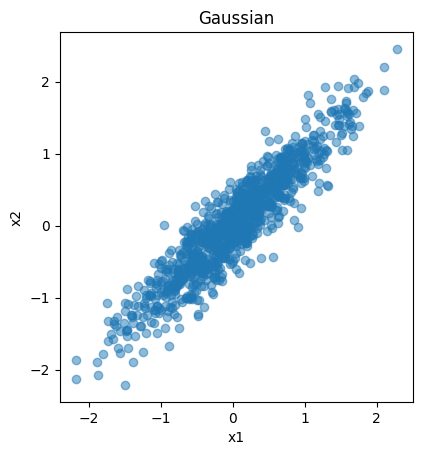

In [88]:
# Load data and scatter plot.
data = np.load("/content/drive/My Drive/HW3_data.npy", allow_pickle=True).item()
gaussian = data["gaussian"]  # (2, 1000)

x1 = gaussian[0,:]
x2 = gaussian[1,:]
plt.scatter(x1, x2, alpha=0.5)
plt.gca().set_aspect('equal')
plt.title("Gaussian")
plt.ylabel("x2")
plt.xlabel("x1")
plt.show()

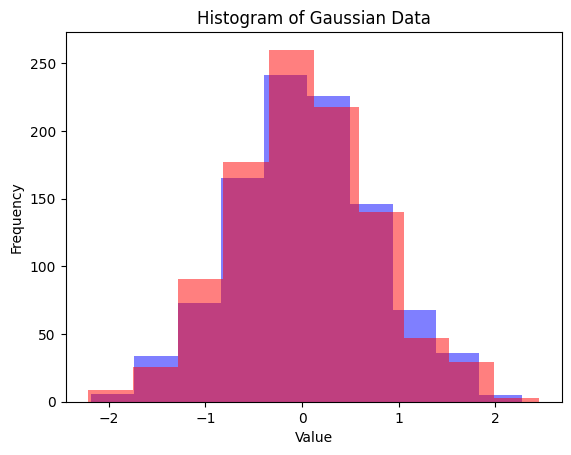

In [89]:
# Plots Each neuron's histogram

plt.hist(gaussian[0,:], color='b', alpha=0.5)
plt.hist(gaussian[1,:], color='r', alpha=0.5)
plt.title("Histogram of Gaussian Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Learned principal components (rows of W):
[[ 0.70294054  0.71124862]
 [-0.70344472  0.71074997]]

True principal components (eigenvectors):
[[-0.70137822 -0.71278931]
 [-0.71278931  0.70137822]]


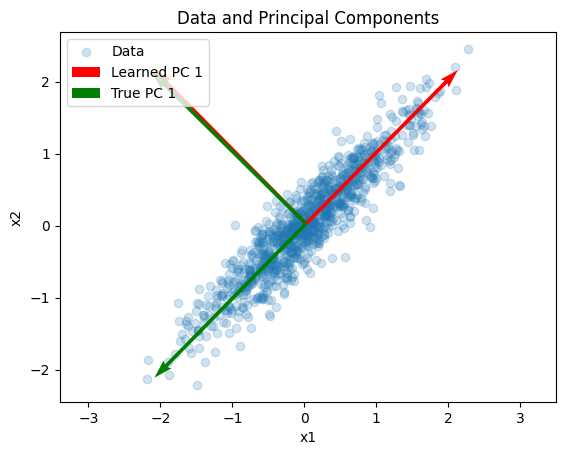

In [90]:
# Training

M = 2 # Number of neurons

def train_neurons(data):
    W_time = [] # Store values for the animation
    # Initialize weight matrix W (shape: M x 2)
    np.random.seed(0)
    W = np.random.randn(M, 2)

    N = 1000 # Samples
    eta = 0.001 # Learning rate
    epochs = 100 # Number of epochs

    u = 0 # Count timepoints for animation

    # Training loop
    for epoch in range(epochs):
        if u % 10 == 0 or u == 0:
          W_time.append(W.copy())

        u += 1
        for i in range(N):
            # Get the current input vector (shape: 2 x 1)
            x = gaussian[:, i].reshape(2, 1)

            # Compute the neuron outputs (shape: M x 1)
            y = W @ x

            # Update weights for each neuron
            for j in range(M):
                # Compute the projection onto previously learned components
                projection = np.zeros((2, 1))
                for k in range(j + 1):
                    projection += y[k] * W[k, :].reshape(2, 1)

                # Update rule for Sanger's algorithm
                delta_w = eta * y[j] * (x - projection).T
                W[j, :] += delta_w.flatten()

      # Normalize the learned weights
    for i in range(M):
        W[i, :] /= np.linalg.norm(W[i, :])

    W_time = np.array(W_time)

    return W, W_time

# Outputs the learned weights
W, W_time = train_neurons(gaussian)

# Compute the covariance matrix of the centered data
cov_matrix = np.cov(gaussian)

# Eigen-decomposition to get true principal components
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort eigenvectors by descending eigenvalues
idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# Normalize eigenvectors
eig_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)

# Print learned and true principal components
print("Learned principal components (rows of W):")
print(W)

print("\nTrue principal components (eigenvectors):")
print(eig_vecs.T)


# Plot the data
plt.scatter(x1, x2, alpha=0.2, label='Data')
plt.title('Data and Principal Components')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

X_mean = np.mean(gaussian, axis=1, keepdims=True)

# Mean of the data for plotting vectors
origin = X_mean.flatten()

# Plot learned principal components
for i in range(M):
    vector = W[i, :] * 3  # Scale for visibility
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='r', label=f'Learned PC {i+1}' if i == 0 else "")

# Plot true principal components
for i in range(M):
    vector = eig_vecs[:, i] * 3  # Scale for visibility
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='g', label=f'True PC {i+1}' if i == 0 else "")

plt.legend()
plt.show()


In [91]:
# Animation for weight vectors evolution

# Prepare the plot for data points (scatter plot)
fig, ax = plt.subplots()
scatter = ax.scatter(x1, x2, alpha=0.2, label='Data')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.axis('equal')

# Mean of the data for plotting vectors
X_mean = np.mean(gaussian, axis=1, keepdims=True)
origin = X_mean.flatten()

# Initialize quiver objects for the learned principal components
quivers = []
for i in range(M):
    vector = W_time[0][i, :] * 3  # Scale for visibility
    quiver = ax.quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='r',
                       label=f'Learned PC {i+1}' if i == 0 else "")
    quivers.append(quiver)

ax.legend()

# Function to update the quiver based on the frame number
def update_quivers(frame):
    for i in range(M):
        vector = W_time[frame][i, :] * 3  # Scale for visibility
        quivers[i].set_UVC(*vector)
    ax.set_title(f'Data and Principal Components - Epoch {frame * 10}')
    return quivers + [ax.title]

# Create the animation
num_epochs = len(W_time)
ani = animation.FuncAnimation(fig, update_quivers, frames=num_epochs, interval=500, blit=True)

# Display the animation
html = HTML(ani.to_jshtml())
display(html)
plt.close()



Letting the training happen for a 100 epochs, neurons learn to have their weight vectors along the directions of maximum variance in the data and perpendicular to it, matching the true PCA components. The first weight vector, the one capturing largest variance, is learned early on by epoch 10, while the other one starts to match the true principal component by epoch 60.

#### ii. Nongaussian dataset

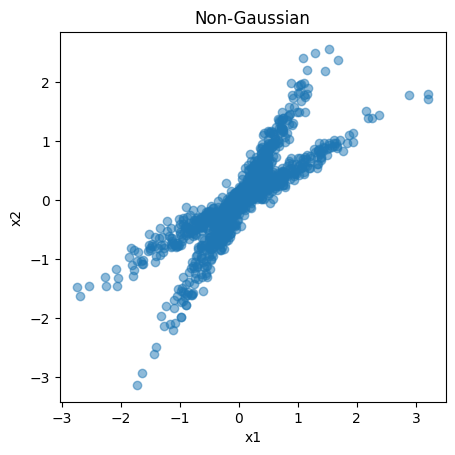

In [92]:
nongaussian = data["nongaussian"]

x1_n = nongaussian[0,:]
x2_n = nongaussian[1,:]
plt.scatter(x1_n, x2_n, alpha=0.5)
plt.gca().set_aspect('equal')
plt.title("Non-Gaussian")
plt.ylabel("x2")
plt.xlabel("x1")
plt.show()


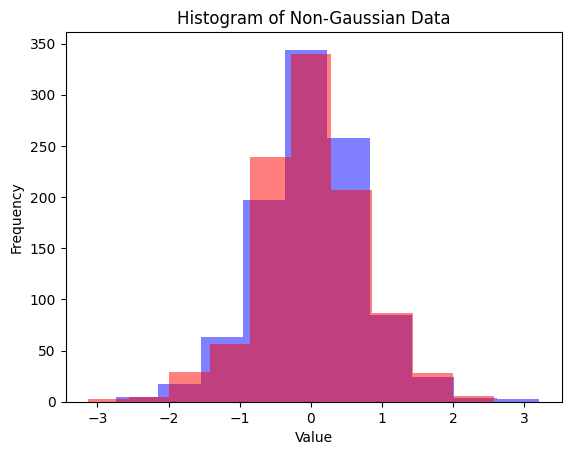

In [93]:
# Plots Each neuron's histogram

plt.hist(nongaussian[0,:], color='b', alpha=0.5)
plt.hist(nongaussian[1,:], color='r', alpha=0.5)
plt.title("Histogram of Non-Gaussian Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

Learned principal components (rows of W):
[[ 0.70294054  0.71124862]
 [-0.70344472  0.71074997]]

True principal components (eigenvectors):
[[-0.70272329 -0.71146327]
 [-0.71146327  0.70272329]]


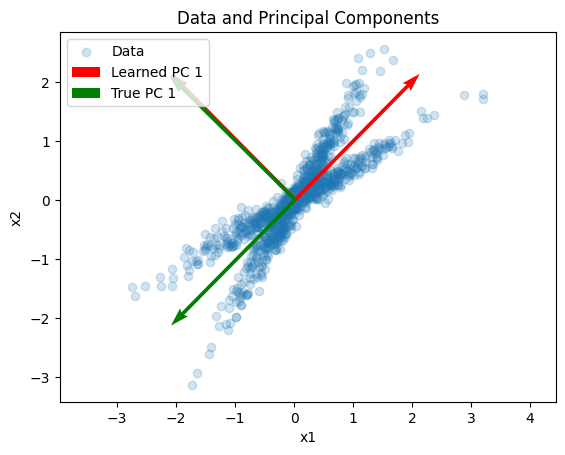

In [ ]:
# Training

M = 2 # Number of neurons

# Outputs the learned weights
W, _ = train_neurons(nongaussian)

# Compute the covariance matrix of the centered data
cov_matrix = np.cov(nongaussian)

# Eigen-decomposition to get true principal components
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort eigenvectors by descending eigenvalues
idx = eig_vals.argsort()[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# Normalize eigenvectors
eig_vecs = eig_vecs / np.linalg.norm(eig_vecs, axis=0)

# Print learned and true principal components
print("Learned principal components (rows of W):")
print(W)

print("\nTrue principal components (eigenvectors):")
print(eig_vecs.T)


# Plot the data
plt.scatter(x1_n, x2_n, alpha=0.2, label='Data')
plt.title('Data and Principal Components')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

X_mean = np.mean(nongaussian, axis=1, keepdims=True)

# Mean of the data for plotting vectors
origin = X_mean.flatten()

# Plot learned principal components
for i in range(M):
    vector = W[i, :] * 3  # Scale for visibility
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='r', label=f'Learned PC {i+1}' if i == 0 else "")

# Plot true principal components
for i in range(M):
    vector = eig_vecs[:, i] * 3  # Scale for visibility
    plt.quiver(*origin, *vector, angles='xy', scale_units='xy', scale=1, color='g', label=f'True PC {i+1}' if i == 0 else "")

plt.legend()
plt.show()


Sagner's rule is unable to learn patterns on the non-gaussian data. Weight vectors don't quite follow the directions of high variance in the data, which in this case should be taking an X shape. It deals with the data as if it was gaussian and thus learns the same weight vectors as the ones for the gaussian data. So, linear Hebbian learning cannor capture the nonlinearity in this data.

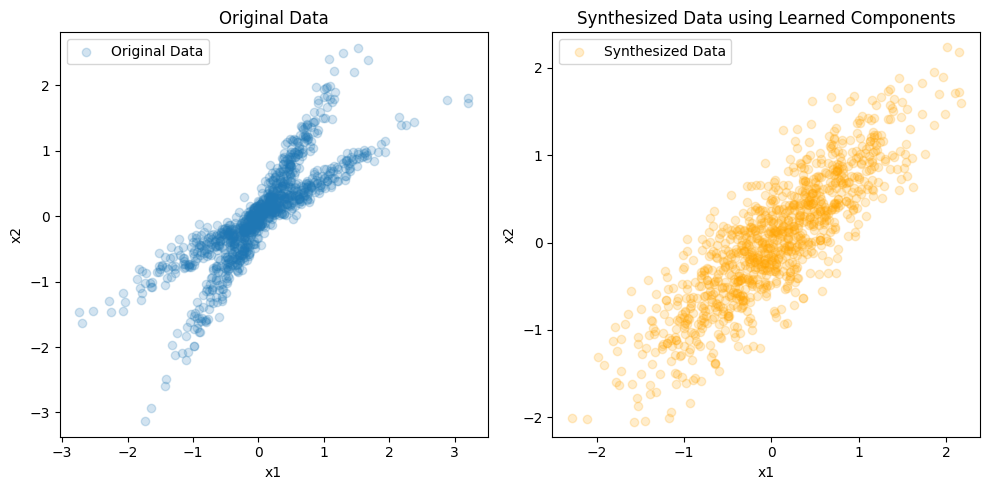

In [ ]:
M = np.shape(nongaussian)[0]
N = np.shape(nongaussian)[1]

# Project the centered data onto the learned principal components
Y = W @ nongaussian  # Shape: M x N

# Compute the variances of the projected neuron outputs
variances = np.var(Y, axis=1, keepdims=True)  # Shape: M x 1

# Synthesize new data using the learned components and their variances
Y_synth = np.random.randn(M, N) * np.sqrt(variances)  # Shape: M x N

# Reconstruct back the synthesized data from the synthetic projections
X_synth = W.T @ Y_synth + X_mean  # Shape: 2 x N

# Plot the original data and the synthesized data
plt.figure(figsize=(10, 5))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(nongaussian[0, :], nongaussian[1, :], alpha=0.2, label='Original Data')
plt.title('Original Data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()

# Synthesized data
plt.subplot(1, 2, 2)
plt.scatter(X_synth[0, :], X_synth[1, :], alpha=0.2, color='orange', label='Synthesized Data')
plt.title('Synthesized Data using Learned Components')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

This figure also proves the same point. The weights learned by Hebbain learning on the non-gaussian data end up synthesizing the gaussian data distributions we were seeing in part i, and it cannot capture the complex non-linear structure of the data.

#### iii. Faces dataset
Download [faces.npy](https://drive.google.com/file/d/1-0BDzikAPLS7lYETRMkf-8EXRNcGdh5M/view?usp=sharing
) and make sure it's under My Drive.

Train a network and show the learned weight vectors.

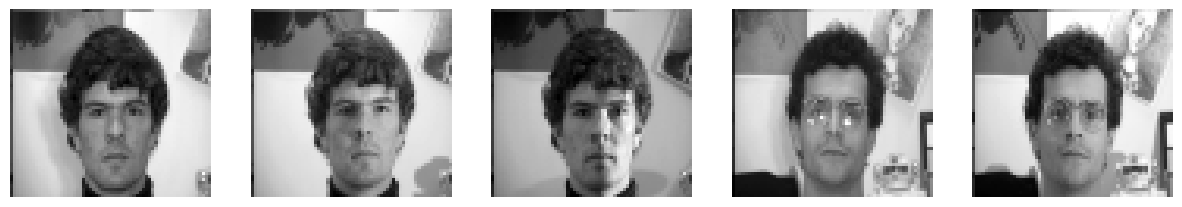

In [ ]:
faces = np.load("/content/drive/My Drive/faces.npy")
# 48 images of size 60x64
faces = np.transpose(faces.T.reshape(-1, 64, 60), (0, 2, 1))  # (48, 60, 64)
# Normalize each image by subtracting the mean such that mean=0 and dividing by
# std such that std=1 (and var=1).
faces = ((faces - np.mean(faces, axis=(1, 2), keepdims=True)) /
         np.std(faces, axis=(1, 2), keepdims=True))

n = 5
sz = np.sqrt(faces.shape[0]).astype(int)
fig, axes = plt.subplots(1, n, figsize=(15, 3))
for i in range(n):
  axes[i].imshow(faces[i], cmap='gray')
  axes[i].axis('off')
plt.show()

In [ ]:
# Number of neurons
M = 5

num_samples = np.shape(faces)[0]
num_features = np.shape(faces)[1] * np.shape(faces)[2]

# Initialize weight matrix
np.random.seed(42)
W = np.random.randn(M, num_features)

# Learning rate
eta = 0.0001

# Number of epochs
epochs = 10

# Training loop, different to adapt for image structure
for epoch in range(epochs):
    for i in range(num_samples):
        # Get the current input vector (shape: num_features x 1)
        x = faces[i, :].reshape(num_features, 1)

        # Compute the neuron outputs (shape: M x 1)
        y = W @ x  # Matrix multiplication

        # Update weights for each neuron
        for j in range(M):
            # Compute the projection onto previously learned components
            projection = np.zeros((num_features, 1))
            for k in range(j + 1):
                projection += y[k, 0] * W[k, :].reshape(num_features, 1)

            # Update rule for Sanger's algorithm
            delta_w = eta * y[j, 0] * (x - projection).T
            W[j, :] += delta_w.flatten()

    # Normalize the weights after each epoch
    for j in range(M):
        W[j, :] /= np.linalg.norm(W[j, :])

    print(f"Epoch {epoch + 1}/{epochs} completed.")



Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


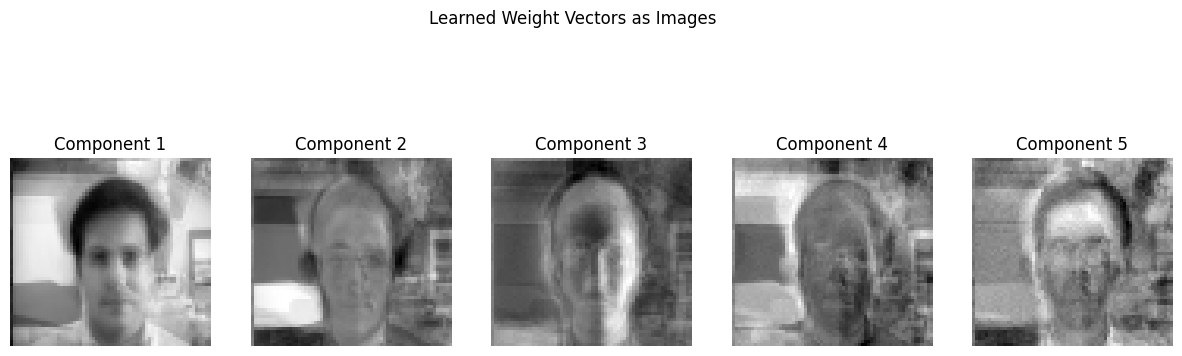

In [ ]:
# Reshape the weight vectors to image dimensions
weight_images = W.reshape((M, 60, 64))

# Display the weight images
fig, axes = plt.subplots(1, M, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(weight_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Component {i + 1}')
plt.suptitle('Learned Weight Vectors as Images')
plt.show()


In this case, every neuron learns an aspect of the data but their resperentations are noisy.

a. Reconstruct one of the images from the five components

In [ ]:
# Select an image to reconstruct
index = 0
original_image = faces[index].reshape(num_features, 1)

# Compute the neuron outputs (activations)
y = W @ original_image

# Reconstruct the image using the five components
reconstructed_image = np.zeros((num_features, 1))
for j in range(M):
    reconstructed_image += y[j, 0] * W[j, :].reshape(num_features, 1)

mean_image = np.mean(faces, axis=0).flatten()
# Add the mean image back to the reconstructed image
reconstructed_image += mean_image.reshape(num_features, 1)

# Reshape images for visualization
original_image_reshaped = (original_image + mean_image.reshape(num_features, 1)).reshape(60, 64)
reconstructed_image_reshaped = reconstructed_image.reshape(60, 64)


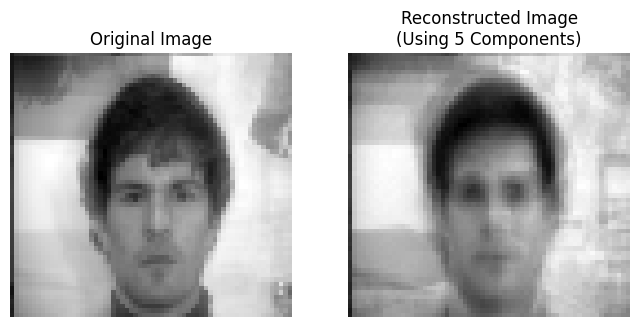

In [ ]:
# Display the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_image_reshaped, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_reshaped, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Reconstructed Image\n(Using 5 Components)')

plt.show()


Here our model constructs one of the faces using the learned weights but with noise added, meaning the model fails to effectively learn details of the faces and adjust its weights accordingly.

b. Visualize the structure by synthesizing images

In [ ]:
# Collect neuron outputs over the dataset
faces_flat = faces.reshape(num_samples, -1)
Y = W @ faces_flat.T  # Shape: (M, num_samples)

# Compute the variance (over samples) for each unit
variances = np.var(Y, axis=1)
print("Variances of each unit:", variances)


Variances of each unit: [ 24.03660592 295.31684132 183.49060999 198.78839575 149.26483599]


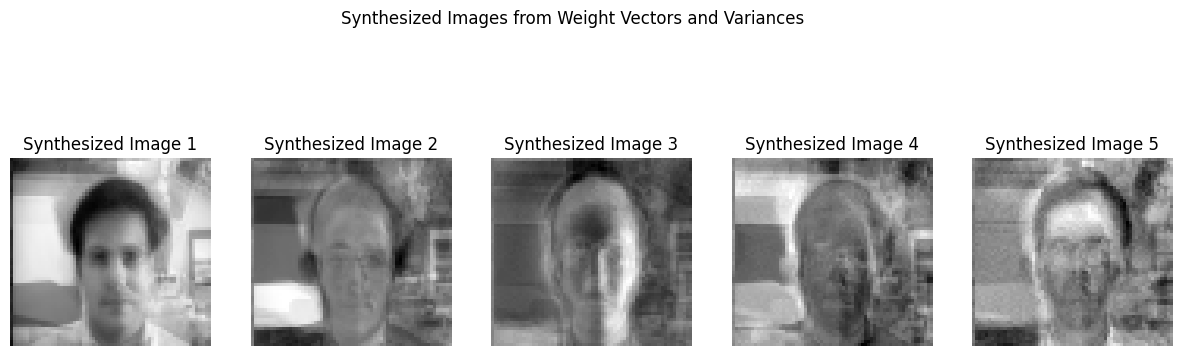

In [ ]:
# Synthesize images
synthesized_images = []
for j in range(M):
    # Scale the weight vector by the variance
    synthesized_image = variances[j] * W[j, :].reshape(60, 64)
    synthesized_images.append(synthesized_image)

# Display the synthesized images
fig, axes = plt.subplots(1, M, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(synthesized_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Synthesized Image {i + 1}')
plt.suptitle('Synthesized Images from Weight Vectors and Variances')
plt.show()


This proves the same point. The model can synthesize some of the details in the images using its learned weights but the outputs it produces are very noisy. It looks like faces are overlaid over each other in the representations. So, linear Hebbian learning using 5 neurons can capture only little complexity in a faces dataset, and its learned weights have a lot of noise added into them.

## Part 2: Winner-take-all
#### i. Train WTA network on the non-Gaussian dataset used in Part 1

In [83]:
class WTANetwork:
    def __init__(self, num_neurons, input_dim, learning_rate=0.1):
        self.num_neurons = num_neurons  # Number of neurons in the network
        self.input_dim = input_dim      # Dimensionality of the input data
        self.learning_rate = learning_rate  # Learning rate (eta)
        # Initialize weights randomly and normalize them
        self.weights = np.random.rand(num_neurons, input_dim)
        self.normalize_weights()

    def normalize_weights(self):
        # Normalize the weight vectors to unit length
        norms = np.linalg.norm(self.weights, axis=1, keepdims=True)
        # Avoid division by zero
        norms[norms == 0] = 1
        self.weights /= norms

    def train(self, data, epochs=10):
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            np.random.shuffle(data)
            for x in data:
              # x is a 1D array of shape (2,)
                # Normalize the input vector x
                x_norm = np.linalg.norm(x)
                if x_norm > 0:
                    x_normalized = x / x_norm  # Shape: (2,)
                else:
                    x_normalized = x
                # Compute activations (dot product with weights)
                activations = self.weights @ x_normalized.T  # Shape: (num_neurons, 1)
                # Determine the winning neuron (the one with the highest activation)
                winner_index = np.argmax(activations)
                # Activation of the winning neuron (ensure non-negative)
                y_k = max(activations[winner_index], 0)
                # Update the weights of the winning neuron
                self.weights[winner_index] += self.learning_rate * (x_normalized - self.weights[winner_index])
                # Normalize the updated weight vector
                self.normalize_weights()  # <-- Ensure weights are normalized
            print(f'Epoch {epoch + 1}/{epochs} completed.')


    def get_weights(self):
        return self.weights



Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


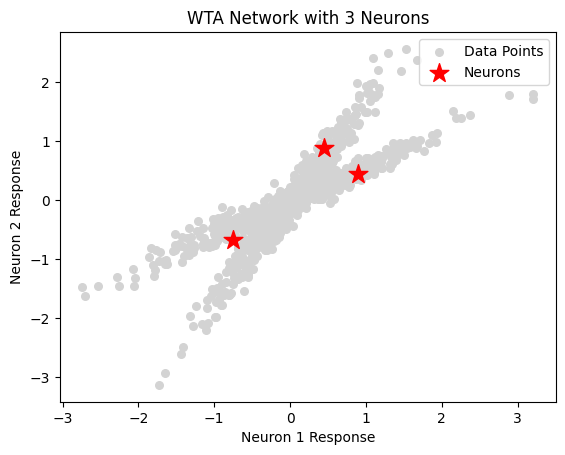

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


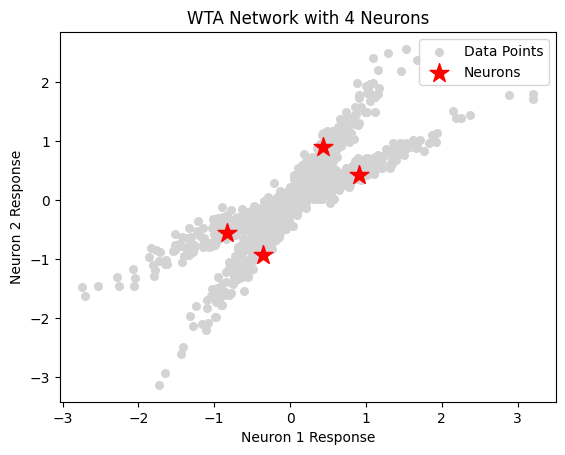

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


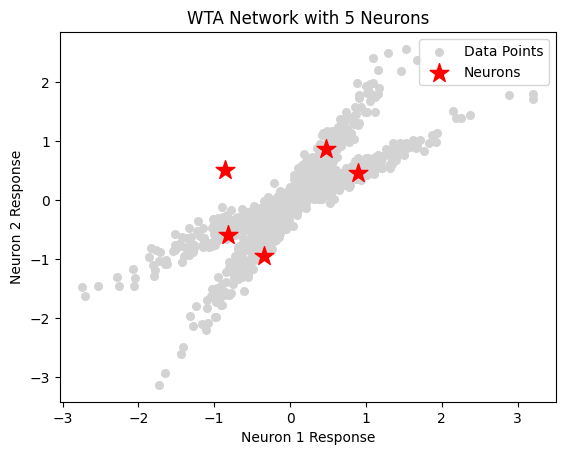

In [94]:
def visualize_wta(data, wta_network, title='WTA Network'):
    weights = wta_network.get_weights()
    plt.scatter(x1_n, x2_n, s=30, c='lightgray', label='Data Points')
    plt.scatter(weights[:, 0], weights[:, 1], s=200, c='red', marker='*', label='Neurons')
    plt.title(title)
    plt.xlabel('Neuron 1 Response')
    plt.ylabel('Neuron 2 Response')
    plt.legend()
    plt.show()


data = nongaussian.T
# Create and train the WTA network with 3 neurons
wta3 = WTANetwork(num_neurons=3, input_dim=2, learning_rate=0.1)
wta3.train(data, epochs=20)

# Visualize the learned weights
visualize_wta(nongaussian, wta3, title='WTA Network with 3 Neurons')

wta4 = WTANetwork(num_neurons=4, input_dim=2, learning_rate=0.1)
wta4.train(data, epochs=20)
visualize_wta(data, wta4, title='WTA Network with 4 Neurons')

# With 5 Neurons
wta5 = WTANetwork(num_neurons=5, input_dim=2, learning_rate=0.1)
wta5.train(data, epochs=20)
visualize_wta(data, wta5, title='WTA Network with 5 Neurons')

Here we can see that the WTA network is able to capture the complex patterns in this non-gaussian dataset. With 3 neurons, two of them specialize in two terminals of the X shape along which the data is spread, and the remaining neuron goes to the terminals' intersection of the other end of the X to capture as much variance as possible. With 4 neurons, we see that every terminal of the 4 terminals of the data's X shape is captured by a neuron, meaning that neurons learn to follow the data variance quite well. With 5 neurons, the extra one seems to not be doing anything sitting in the transverse direction.

#### ii. Train WTA on faces dataset

In [ ]:
class WTANetwork:
    def __init__(self, num_neurons, input_dim, learning_rate=0.01):
        self.num_neurons = num_neurons  # Number of neurons in the network
        self.input_dim = input_dim      # Dimensionality of the input data
        self.learning_rate = learning_rate
        # Initialize weights randomly and normalize them
        self.weights = np.random.rand(num_neurons, input_dim)*0.001
        self.normalize_weights()

    def normalize_weights(self):
        # Normalize the weight vectors to unit length
        norms = np.linalg.norm(self.weights, axis=1, keepdims=True)
        # Avoid division by zero
        norms[norms == 0] = 1
        self.weights /= norms

    def train(self, data, epochs=10):
        num_samples = data.shape[0]
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            indices = np.random.permutation(num_samples)
            for idx in indices:
                x = data[idx]
                # Normalize the input vector x
                x_norm = np.linalg.norm(x)
                if x_norm > 0:
                    x_normalized = x / x_norm
                else:
                    x_normalized = x
                # Compute activations
                activations = self.weights @ x_normalized
                # Determine the winning neuron (the one with the highest activation)
                winner_index = np.argmax(activations)
                # Activation of the winning neuron (ensure non-negative)
                y_k = max(activations[winner_index], 0)
                # Update the weights of the winning neuron
                self.weights[winner_index] += self.learning_rate * (x - self.weights[winner_index])
                # Normalize the updated weight vector
                self.normalize_weights()  # <-- Ensure weights are normalized


            print(f'Epoch {epoch + 1}/{epochs} completed.')


    def get_weights(self):
        return self.weights


Epoch 1/100 completed.
Epoch 2/100 completed.
Epoch 3/100 completed.
Epoch 4/100 completed.
Epoch 5/100 completed.
Epoch 6/100 completed.
Epoch 7/100 completed.
Epoch 8/100 completed.
Epoch 9/100 completed.
Epoch 10/100 completed.
Epoch 11/100 completed.
Epoch 12/100 completed.
Epoch 13/100 completed.
Epoch 14/100 completed.
Epoch 15/100 completed.
Epoch 16/100 completed.
Epoch 17/100 completed.
Epoch 18/100 completed.
Epoch 19/100 completed.
Epoch 20/100 completed.
Epoch 21/100 completed.
Epoch 22/100 completed.
Epoch 23/100 completed.
Epoch 24/100 completed.
Epoch 25/100 completed.
Epoch 26/100 completed.
Epoch 27/100 completed.
Epoch 28/100 completed.
Epoch 29/100 completed.
Epoch 30/100 completed.
Epoch 31/100 completed.
Epoch 32/100 completed.
Epoch 33/100 completed.
Epoch 34/100 completed.
Epoch 35/100 completed.
Epoch 36/100 completed.
Epoch 37/100 completed.
Epoch 38/100 completed.
Epoch 39/100 completed.
Epoch 40/100 completed.
Epoch 41/100 completed.
Epoch 42/100 completed.
E

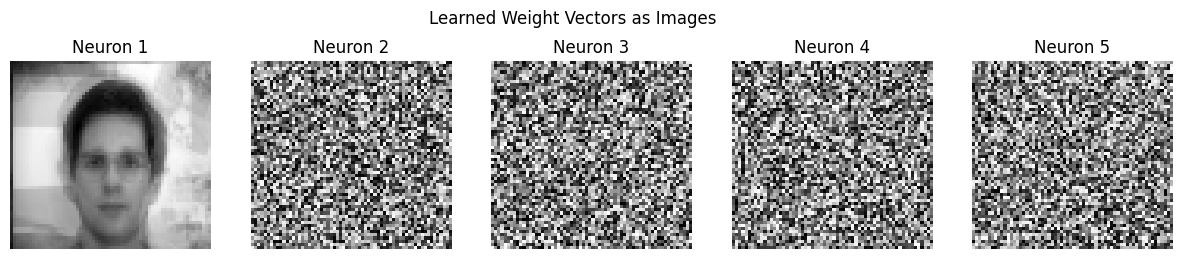

In [76]:
# Create and train the WTA network
wta_network = WTANetwork(num_neurons=5, input_dim=3840, learning_rate=0.01)
wta_network.train(faces_flat, epochs=100)

# Get the learned weights
learned_weights = wta_network.get_weights()

# Reshape the weight vectors to image dimensions
weight_images = learned_weights.reshape((5, 60, 64))
# Normalize weight images for display
weight_images_norm = (weight_images - weight_images.min(axis=(1,2), keepdims=True)) / \
                     (weight_images.max(axis=(1,2), keepdims=True) - weight_images.min(axis=(1,2), keepdims=True) + 1e-8)

# Display the weight images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(weight_images_norm[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Neuron {i + 1}')
plt.suptitle('Learned Weight Vectors as Images')
plt.show()


Applying WTA to the faces dataset, we can see every time the network is run, only one neuron specializes to capture the information in the data by learning a weight vector that is just one of the images with some noise. All other neurons fail to capture anything but noise. This could be due to the high complexity of the face images and having only 5 neurons in the model. Also the inherent competition in the WTA network might have led up to only one neuron winning to capture some details of the data.

## Part 3: Foldiak's sparse coding model
Download [bars.npy](https://drive.google.com/file/d/1-8NGwsAy3pjf9JrEdJdB4AdH4gvnVPqx/view?usp=sharing) and make sure it's under My Drive.

#### i. Implement Foldiak's network, plot learned weights and thresholds

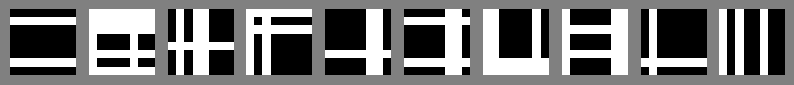

In [95]:
bars = np.load("/content/drive/My Drive/bars.npy")  # (10000, 8, 8)

n=10
fig, axes = plt.subplots(1, n, figsize=(10, 2))
fig.patch.set_facecolor("gray")
for i in range(n):
  axes[i].imshow(bars[i], cmap="gray")
  axes[i].axis('off')
plt.show()

# Flatten the data
barss = bars.reshape(10000, -1)

Epoch 0, Average activation: 0.0434
Max weight: 0.3266, Min weight: -0.4109
Max threshold: 0.6601, Min threshold: 0.0000
Epoch 10, Average activation: 0.0431
Max weight: 0.3438, Min weight: -0.3906
Max threshold: 0.7739, Min threshold: 0.0000
Epoch 20, Average activation: 0.0493
Max weight: 0.3359, Min weight: -0.3906
Max threshold: 0.7564, Min threshold: 0.0000
Epoch 30, Average activation: 0.0520
Max weight: 0.3289, Min weight: -0.3906
Max threshold: 0.7113, Min threshold: 0.0000
Epoch 40, Average activation: 0.0557
Max weight: 0.3246, Min weight: -0.3906
Max threshold: 0.7776, Min threshold: 0.0000
Epoch 50, Average activation: 0.0562
Max weight: 0.3381, Min weight: -0.3906
Max threshold: 0.7635, Min threshold: 0.0000
Epoch 60, Average activation: 0.0562
Max weight: 0.3381, Min weight: -0.3906
Max threshold: 0.7635, Min threshold: 0.0000
Epoch 70, Average activation: 0.0562
Max weight: 0.3381, Min weight: -0.3906
Max threshold: 0.7635, Min threshold: 0.0000
Epoch 80, Average activat

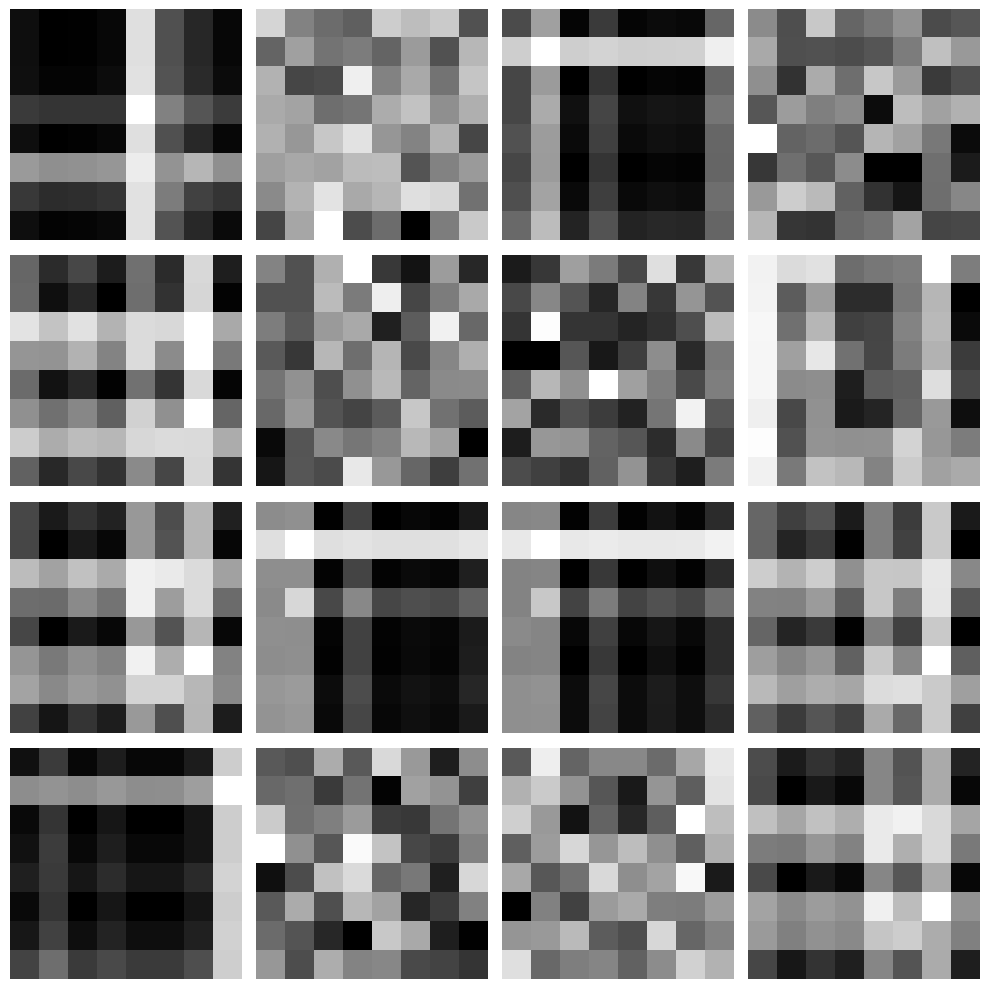

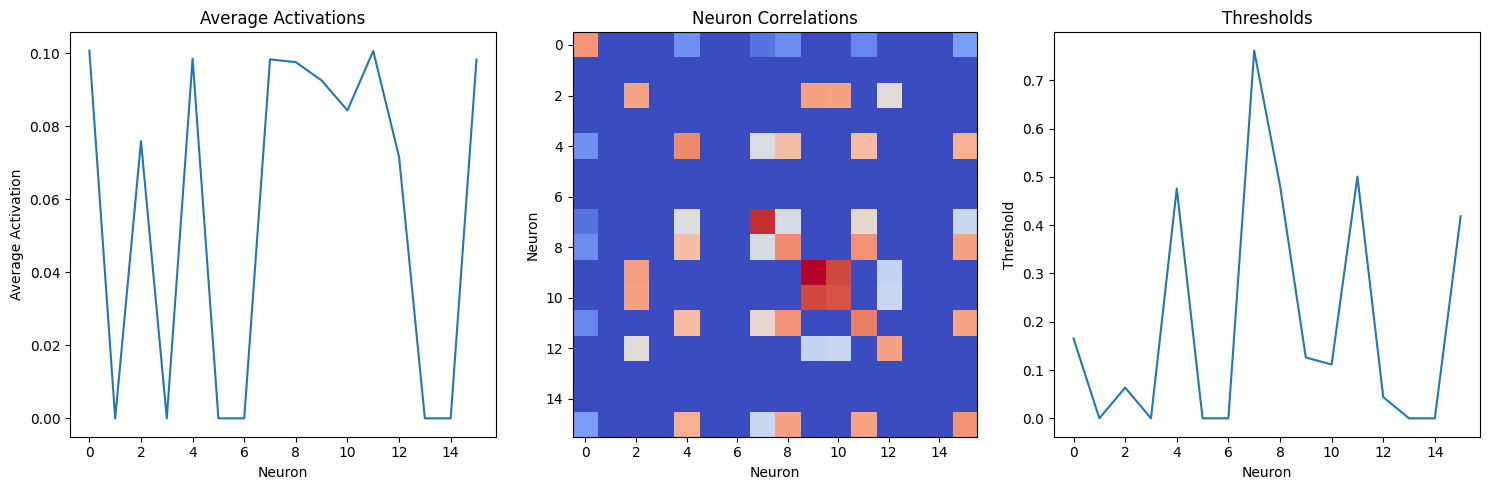

In [75]:
import numpy as np
import matplotlib.pyplot as plt

class FoldiakNetwork:
    def __init__(self, input_size, num_neurons, learning_rate=0.1, threshold=0.1, target_sparsity=0.1):
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.target_sparsity = target_sparsity

        # Initialize weights and lateral connections
        self.feedforward_weights = np.random.randn(num_neurons, input_size)
        self.lateral_weights = np.random.rand(num_neurons, num_neurons) * 0.1
        np.fill_diagonal(self.lateral_weights, 0)

        self.thresholds = np.ones(num_neurons) * threshold

        # For tracking
        self.average_activations = np.zeros(num_neurons)
        self.correlations = np.zeros((num_neurons, num_neurons))

    def activate(self, input_data):
        # Feedforward activation
        activation = np.dot(self.feedforward_weights, input_data)

        # Lateral inhibition
        for _ in range(5):  # Iterate a few times for stability
            previous_activation = activation.copy()
            inhibition = np.dot(self.lateral_weights, activation)
            activation = np.maximum(activation - inhibition - self.thresholds, 0)
            if np.allclose(activation, previous_activation, atol=1e-4):
                break  # Stop if the activation stabilizes


        return activation

    def update_weights(self, input_data, activation):
        # Hebbian learning for feedforward weights
        delta_w = np.outer(activation, input_data) - self.feedforward_weights * (np.sum(activation) / self.num_neurons)
        self.feedforward_weights += self.learning_rate * delta_w
        self.feedforward_weights /= np.linalg.norm(self.feedforward_weights, axis=1, keepdims=True) + 1e-8

        # Update lateral weights (anti-Hebbian inhibition between neurons)
        delta_l = np.outer(activation, activation)
        np.fill_diagonal(delta_l, 0)  # Ensure no self-connections
        self.lateral_weights -= self.learning_rate * delta_l

        # Normalize lateral weights (row-wise normalization to keep balance)
        row_norms = np.linalg.norm(self.lateral_weights, axis=1, keepdims=True)
        self.lateral_weights /= np.maximum(row_norms, 1e-8)  # Avoid division by zero with small constant
        self.lateral_weights = np.maximum(self.lateral_weights, 0)  # Ensure non-negativity

        # Update thresholds to maintain desired sparsity
        self.thresholds += self.learning_rate * (activation - self.target_sparsity)
        self.thresholds = np.clip(self.thresholds, 0, np.max(self.thresholds)) # Ensure non-negativity

        # Update average activations and correlations using stable moving averages
        self.average_activations = 0.99 * self.average_activations + 0.01 * activation
        self.correlations = 0.99 * self.correlations + 0.01 * np.outer(activation, activation)

    def train(self, dataset, epochs):
        '''
        Carry out the training process
        '''
        for epoch in range(epochs):
            total_activation = np.zeros(self.num_neurons)
            for data in dataset:
                activation = self.activate(data)
                self.update_weights(data, activation)
                total_activation += activation

            avg_activation = total_activation / len(dataset)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Average activation: {np.mean(avg_activation):.4f}")
                print(f"Max weight: {np.max(self.feedforward_weights):.4f}, Min weight: {np.min(self.feedforward_weights):.4f}")
                print(f"Max lat weight: {np.max(self.lateral_weights):.4f}, Min lat weight: {np.min(self.lateral_weights):.4f}")
                print(f"Max threshold: {np.max(self.thresholds):.4f}, Min threshold: {np.min(self.thresholds):.4f}")

    def plot_learned_features(self):
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(self.feedforward_weights[i].reshape(8, 8), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_training_progress(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        ax1.plot(self.average_activations)
        ax1.set_title('Average Activations')
        ax1.set_xlabel('Neuron')
        ax1.set_ylabel('Average Activation')

        ax2.imshow(self.correlations, cmap='coolwarm')
        ax2.set_title('Neuron Correlations')
        ax2.set_xlabel('Neuron')
        ax2.set_ylabel('Neuron')

        ax3.plot(self.thresholds)
        ax3.set_title('Thresholds')
        ax3.set_xlabel('Neuron')
        ax3.set_ylabel('Threshold')

        plt.tight_layout()
        plt.show()


network = FoldiakNetwork(input_size=64, num_neurons=16, learning_rate=0.1, threshold=0.1, target_sparsity=0.1)
network.train(barss, epochs=200)

network.plot_learned_features()
network.plot_training_progress()

Here, the Foldiak's sparse coding model with 16 neurons trained on patterns in the bars data did an average job in learning useful weight matrices for bar patterns' representations. First, we can see that the sparsity condition, controlled by the sparsity parameter in the code (here 0.1) is satisfied where around half the neurons have an average activation of zero, and the overall activation is low. In the correlation matrix, we see that apart from diagional values for same-neuron, correlations between neurons are generally low which is what we expect from the anti-Hebbian learning. This can also be inferred from the thresholds plot where neurons have different thresholds which is due to the model's sparsity constraint where only some neurons respond generally to inputs (neurons with low thresholds) and others do not or specialize in only specific input patterns. The learned wight matrices for some neurons show some bar-like patterns. For others, however, they seem to not have learned much discernible detail.

On the other hand, In this code cell I didn't plot the evolution of thresholds and lateral weights throughout learning but printed their values every 10 epochs. We can see that weights and thresholds converge quite early, around epoch 50.